# EXPERIMENTO 10: "LEY DE OERSTED"


El objetivo de esta experiencia es recrear el famoso experimento de Oersted sobre la desviación que sufre una aguja magnética situada en las proximidades de un conductor eléctrico

Através de esta ley se puede determinar el valor de **campo magnético** de un conductor

$$ \vec{B}_C = \frac{\mu_0 I}{2 \pi d} $$

Referencias:

$I$: medir en laboratorio.

$d$: distancia de separación entre el conductor y la aguja.

**FÓRMULAS PARA EL MÉTODO DE LOS MÍNIMOS CUADRADOS**

Ecuación de la recta: $y = Ax + B$
* Para determinar la pendiente $A$
$$A =\frac{n\sum x_i y_i - \sum x_i \sum y_i}{n \sum{x_i}^{2} - \left( \sum x_i \right)^{2}}$$
* Para determinar el término independiente $B$
$$B =\frac{\sum y_i \sum {x_i}^{2} - \sum x_i \sum x_i y_i}{n \sum{x_i}^{2} - \left( \sum x_i \right)^{2}}$$
* Para determinar la incertidumbre de los datos
$$\sigma_y =\sqrt{\frac{\sum{\left(y_i - Bx_i - A\right)}^{2}}{n-2}}$$
* Para determinar la incertidumbre de $A$
$$E_A = \sigma_y \sqrt{\frac{\sum{x_i}^{2}}{n \sum{x_i}^{2} - \left( \sum x_i \right)^{2}}}$$
* Para determinar la incertidumbre de $B$
$$E_B = \sigma_y \sqrt{\frac{n}{n \sum{x_i}^{2} - \left( \sum x_i \right)^{2}}}$$
* Para determinar el coeficiente de correlación
$$r =\frac{\sum x_i y_i}{\sqrt{\sum{x_i}^{2} \sum{y_i}^{2}}}$$

Librerias necesarias

In [113]:
from __future__ import annotations
import numpy as np
import six
import math
from matplotlib import pyplot
# from matplotlib.lines import lineStyles
# from IPython.display import Image
# import ipyplot

Clases implementadas para aplicar el método de los mínimos cuadrados.

In [114]:
from enum import Enum, unique


@unique
class Operation(Enum):
    ADD = 0
    SUB = 1
    MUL = 2
    TRUEDIV = 3
    FLOORDIV = 4
    POW = 5
    MOD = 6


class LException(Exception):

    def __init__(self, *args):
        super(LException, self).__init__(*args)


class List(list):
    """
    @author: Edgar Alejo Ramirez
    """

    def __init__(self):
        super().__init__()

    def __add__(self, other: int | float | List):
        return self.__fun(other, Operation.ADD)

    def __sub__(self, other: int | float | List):
        return self.__fun(other, Operation.SUB)

    def __mul__(self, other: int | float | List):
        return self.__fun(other, Operation.MUL)

    def __truediv__(self, other: int | float | List):
        return self.__fun(other, Operation.TRUEDIV)

    def __floordiv__(self, other: int | float | List):
        return self.__fun(other, Operation.FLOORDIV)

    def __pow__(self, power: int | List, modulo = None):
        return self.__fun(power, Operation.POW)

    def __mod__(self, other: int | float | List):
        return self.__fun(other, Operation.MOD)

    def __op(self, other: int | float | List, operation: Operation, array: bool = False) -> List:
        values = List()
        for i in range(len(self)):
            if operation == Operation.ADD:
                values.append(self[i] + other[i] if array else self[i] + other)
            elif operation == Operation.SUB:
                values.append(self[i] - other[i] if array else self[i] - other)
            elif operation == Operation.MUL:
                values.append(self[i] * other[i] if array else self[i] * other)
            elif operation == Operation.TRUEDIV:
                values.append(self[i] / other[i] if array else self[i] / other)
            elif operation == Operation.FLOORDIV:
                values.append(self[i] // other[i] if array else self[i] // other)
            elif operation == Operation.POW:
                values.append(self[i] ** other[i] if array else self[i] ** other)
            elif operation == Operation.MOD:
                values.append(self[i] % other[i] if array else self[i] % other)
            else:
                raise LException(f"invalid operation")
        return values

    def __fun(self, other: int | float | List, op: Operation):
        if isinstance(other, (int, float)):
            return self.__op(other, op)
        elif isinstance(other, List):
            if len(self) == len(other):
                return self.__op(other, op, array = True)
            else:
                raise LException(f"lists must be of equal size")
        else:
            raise LException(f"only types are supported: {int}, {float} and {List}")

In [115]:
from csv import writer, reader


class LRException(Exception):
    def __init__(self, *args):
        super(LRException, self).__init__(*args)


class LeastSquares:
    """
    @author: Edgar Alejo Ramirez
    """

    def __init__(self, data: dict | str):
        self.__array: dict
        self.__path: str

        if isinstance(data, dict):
            self.__array = data
        elif isinstance(data, str):
            self.__path = data
            self.__array = {key: value for key, value in self.__readcsv()}
        else:
            raise LRException(f'Required data types: {dict} or path of *.csv file {str}')

        self.__n = len(self)

        self.__promx = None
        self.__promy = None

        self.__sumx = None
        self.__sumy = None
        self.__sumx2 = None
        self.__sumy2 = None
        self.__sumxy = None

        self.__columnx = None
        self.__columny = None

        self.__x = None
        self.__y = None

    def __len__(self):
        return self.dimension()[1]

    def __getitem__(self, index):
        try:
            return self.__array[index]
        except KeyError as e:
            raise LRException(f"column {e} does not exist")

    def __setitem__(self, index, value):
        self.__array[index] = value

    def __defx(self):
        self.__promx = np.mean(self[self.__columnx])
        self.__sumx = np.sum(self[self.__columnx])
        self.__sumx2 = np.sum(self[self.__columnx] ** 2)

    def __defy(self):
        self.__promy = np.mean(self[self.__columny])
        self.__sumy = np.sum(self[self.__columny])
        self.__sumy2 = np.sum(self[self.__columny] ** 2)

    def __defxy(self):
        self.__sumxy = np.sum(self[self.__columnx] * self[self.__columny])

    def __validate(self):
        if self.__columnx is None or self.__columny is None:
            raise LRException(f"you must specify columns x and y")

    def __readcsv(self):
        with open(self.__path, newline = '') as file:
            values = List()
            for r in reader(file):
                values.append(r)
            values = self.__invert(values)
            for val in values:
                lt = List()
                for v in val[1:]:
                    lt.append(float(v))
                yield str(val[0]), lt

    def __writecsv(self):
        with open(self.__path, mode = 'w') as File:
            write = writer(File)
            write.writerow(self.__array)

    @staticmethod
    def __invert(array: List) -> List:
        val = List()
        for i in range(len(array[0])):
            aux = List()
            for j in range(len(array)):
                aux.append(array[j][i])
            val.append(aux)
        return val

    @staticmethod
    def __round(decimals: int, formula: float) -> float:
        if decimals is None:
            return formula
        if not isinstance(decimals, int):
            raise LRException(f"only {int} type values are supported")
        if decimals < 0:
            raise LRException(f"only positive values including zero are allowed")
        return round(formula, decimals)

    def a(self, decimals: int = None) -> float:
        """
        Pendiente de la recta. fórmula
        :return:
        """
        self.__validate()
        tmp = (self.__n * self.__sumxy - self.__sumx * self.__sumy) / (self.__n * self.__sumx2 - self.__sumx ** 2)
        return self.__round(decimals = decimals, formula = tmp)

    def b(self, decimals: int = None) -> float:
        """
        Término independiente de la recta.
        :return:
        """
        self.__validate()
        tmp = (self.__sumy * self.__sumx2 - self.__sumx * self.__sumxy) / (self.__n * self.__sumx2 - self.__sumx ** 2)
        return self.__round(decimals = decimals, formula = tmp)

    def r(self, decimals: int = None) -> float:
        """
        Coeficiente de correlación.
        :return:
        """
        self.__validate()
        tmp = np.sum(
            (self[self.__columnx] - self.__promx) * (self[self.__columny] - self.__promy)
        ) / (math.sqrt(
            np.sum((self[self.__columnx] - self.__promx) ** 2)
        ) * math.sqrt(
            np.sum((self[self.__columny] - self.__promy) ** 2)
        ))
        return self.__round(decimals = decimals, formula = tmp)

    def sigmay(self, decimals: int = None) -> float:
        """
        Incertidumbre de datos.
        :return:
        """
        self.__validate()
        tmp = math.sqrt(
            np.sum(
                (self[self.__columny] - (self[self.__columnx] * self.a()) - self.b()) ** 2
            ) / (self.__n - 2)
        )
        return self.__round(decimals = decimals, formula = tmp)

    def erra(self, decimals: int = None) -> float:
        """
        Incertidumbre de la pendiente.
        :return:
        """
        self.__validate()
        tmp = self.sigmay() * math.sqrt(self.__n / (self.__n * self.__sumx2 - self.__sumx ** 2))
        return self.__round(decimals = decimals, formula = tmp)

    def errb(self, decimals: int = None) -> float:
        """
        Incertidumbre del término independiente.
        :return:
        """
        self.__validate()
        tmp = self.sigmay() * math.sqrt(self.__sumx2 / (self.__n * self.__sumx2 - self.__sumx ** 2))
        return self.__round(decimals = decimals, formula = tmp)

    def equation(self, decimals: int = None, uncertainty: bool = False) -> str:
        """
        Ecuación de la recta.
        :return:
        """
        b = self.b(decimals)
        sign = "+" if b > 0 else "-"
        if not isinstance(uncertainty, bool):
            raise LRException(f"{uncertainty} not of type {bool}")
        if uncertainty:
            return f"{self.__y} = ({self.a(decimals)} ± {self.erra(decimals)}){self.__x} {sign} ({abs(b)} ± {self.errb(decimals)})"
        return f"{self.__y} = {self.a(decimals)}{self.__x} {sign} {abs(b)}"

    def table(
        self,
        decimals: int = 3,
        colwidth: int | float = 3.0,
        rowheight: int | float = 0.625,
        fontsize: int | float = 14,
        headercolor: str = '#40466e',
        rowcolors: list[str] = None,
        edgecolor: str = 'w',
        bbox: list[int] = None,
        headercolumns: int = 0,
        ax = None,
        **kwargs
    ) -> None:
        if bbox is None:
            bbox = [0, 0, 1, 1]
        if rowcolors is None:
            rowcolors = ['#f1f1f2', 'w']
            # rowcolors = ['#c2c2d6', 'w']
        if ax is None:
            size = (np.array(self.dimension()) + np.array([0, 1])) * np.array([colwidth, rowheight])
            fig, ax = pyplot.subplots(figsize = size)
            ax.axis('off')
        values = [i for i in self.__array.values()]
        values = np.round(values, decimals = decimals)
        values = self.__invert(values)
        mtable = ax.table(cellText = values, bbox = bbox, colLabels = self.headers(), **kwargs)
        mtable.auto_set_font_size(False)
        mtable.set_fontsize(fontsize)

        for k, cell in six.iteritems(mtable.get_celld()):
            cell.set_edgecolor(edgecolor)
            if k[0] == 0 or k[1] < headercolumns:
                cell.set_text_props(weight = 'bold', color = 'w')
                cell.set_facecolor(headercolor)
            else:
                cell.set_facecolor(rowcolors[k[0] % len(rowcolors)])
        pyplot.show()

    def graph(
        self, title = "GRAPH", linewidth = 3,
        pointsize = 200, savepng: bool = False,
        xlabel: str = None, ylabel: str = None,
        decimals: int = None,
        uncertainty: bool = False
    ) -> None:
        self.__validate()
        diff_linewidth = 1.05
        color = ['darkorange', 'olive', 'teal', 'violet', 'skyblue']
        pyplot.figure(facecolor = '#a3a3c2')
        pyplot.scatter(
            self[self.__columnx], self[self.__columny],
            edgecolors = "black", c = color, s = pointsize, marker = "o"
        )
        pyplot.plot(
            self[self.__columnx],
            self.a() * self[self.__columnx] + self.b(),
            c = "blue", linewidth = 2 + (diff_linewidth * linewidth),
            label = self.equation(decimals, uncertainty) + "\nr = " + str(self.r(decimals))
        )
        pyplot.xlabel(self.__x if xlabel is None else xlabel, fontweight = "bold")
        pyplot.ylabel(self.__y if ylabel is None else ylabel, fontweight = "bold")
        pyplot.title(title, fontweight = "bold")
        if savepng:
            pyplot.savefig('graph.png', dpi = 800)
        gca = pyplot.gca()
        gca.set_facecolor('#f0f0f5')
        pyplot.grid(True, linestyle = '--')
        pyplot.legend()

    def dimension(self) -> tuple:
        row = 0
        for v in self.__array.values():
            row = len(v)
        return len(self.__array), row

    def headers(self) -> list:
        return [k for k in self.__array.keys()]

    @property
    def x(self):
        return self.__columnx

    @x.setter
    def x(self, value: tuple):
        if isinstance(value, tuple):
            self.__columnx = value[0]
            self.__x = value[1]
            self.__defx()
            if self.__columny is not None:
                self.__defxy()
        else:
            raise LRException(f"allowed values of type {str}")

    @property
    def y(self):
        return self.__columny

    @y.setter
    def y(self, value: tuple):
        if isinstance(value, tuple):
            self.__columny = value[0]
            self.__y = value[1]
            self.__defy()
            if self.__columnx is not None:
                self.__defxy()
        else:
            raise LRException(f"allowed values of type {str}")

Montaje

![si](../lab10/images/mounting.png)

Datos obtenidos en el laboratorio

![hola](../lab10/images/values.png)

Creando un objeto de tipo **LeastSqueare** "método de los mínimos cuadrados".

In [116]:
ls = LeastSquares("../lab10/models/datas.csv")

Mostrando la tabla de datos obtenidos en el laboratorio.

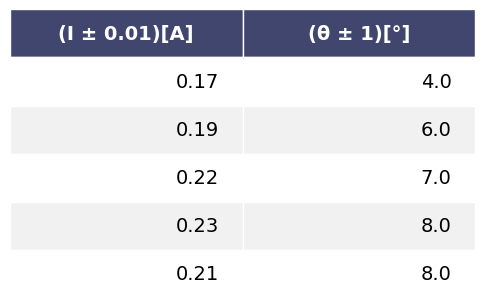

In [117]:
ls.table()

Asignando las columnas que debe de tomar ecuenta para el analisis.

In [118]:
ls.x = ("(I ± 0.01)[A]", "I")
ls.y = ("(θ ± 1)[°]", "tan(θ)")

Valor de la pendiente

In [119]:
ls.a()

63.79310344827512

Valor del término independiente

In [120]:
ls.b()

-6.413793103448229

Valor del coeficiente de correlación

In [121]:
ls.r()

0.9181395839231105

Incertidumbre de la pendiente

In [122]:
ls.erra()

15.89576630567737

Incertidumbre del término independiente

In [123]:
ls.errb()

3.2607637543362924

Ecuación de la recta

In [124]:
out = ls.equation(decimals = 2, uncertainty = True)
print(out)

tan(θ) = (63.79 ± 15.9)I - (6.41 ± 3.26)


Gráfica de tendencia

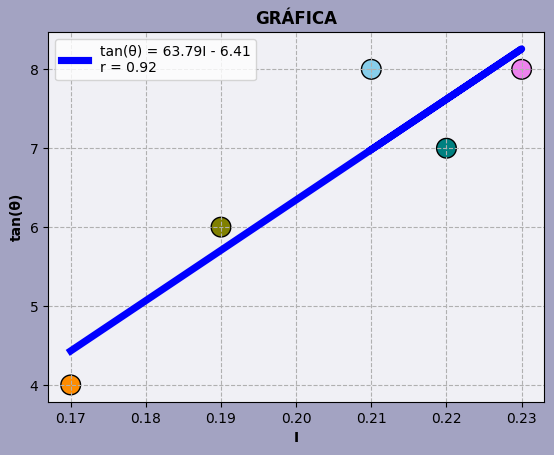

In [125]:
ls.graph(title = "GRÁFICA", pointsize = 200, linewidth = 3, decimals = 2, uncertainty = False, savepng = False)

In [126]:
# pyplot.quiver([0, 4], [0, 4], [0, 0], [4, 4], scale_units = "xy", angles = "xy", scale = 1)
# pyplot.xlim(-1, 5)
# pyplot.ylim(-1, 5)
# pyplot.grid(True, linestyle = "--")
# ax = pyplot.gca()
# ax.set_facecolor('#f0f0f5')
# axes = pyplot.axes()
#
# axes.spines['bottom'].set_linewidth(2)
# axes.spines['left'].set_linewidth(2)
# axes.spines['top'].set_visible(False)
# axes.spines['right'].set_visible(False)
# pyplot.show()